# Task 3B 
In this Section we have fine tune our Task 3A RCAN model to get better results on low-resolution strong lensing images using a limited dataset of real HR/LR pairs collected from HSC and HST telescopes.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import os 
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
image_LR = np.load('3B/LR/LR_1.npy')
image_HR = np.load('3B/HR/HR_1.npy')
print(image_LR.shape)
print(image_HR.shape)

(1, 64, 64)
(1, 128, 128)


In [4]:

class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.lr_dir = os.path.join(self.root_dir, 'LR')  # Low-resolution images directory
        self.hr_dir = os.path.join(self.root_dir, 'HR')  # High-resolution images directory
        self.image_files = [f for f in os.listdir(self.lr_dir) if os.path.isfile(os.path.join(self.lr_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        lr_path = os.path.join(self.lr_dir, self.image_files[idx])
        hr_path = os.path.join(self.hr_dir, self.image_files[idx].replace('LR', 'HR'))  # Assuming HR files have the same name with 'HR' instead of 'LR'
        
        lr_image = np.load(lr_path)
        hr_image = np.load(hr_path)

        sample = {'lr': lr_image, 'hr': hr_image}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']

        # Convert numpy arrays to torch tensors
        lr = torch.from_numpy(lr).float()
        hr = torch.from_numpy(hr).float()

        # Add a channel dimension if necessary
        if lr.ndim == 2:
            lr = lr.unsqueeze(0)
        if hr.ndim == 2:
            hr = hr.unsqueeze(0)

        return {'lr': lr, 'hr': hr}

In [5]:
from torch.utils.data import random_split
transform = transforms.Compose([ToTensor()])
dataset = SuperResolutionDataset(root_dir='3B', transform=transform)
print(len(dataset))

total_size = len(dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

300


In [6]:
# If you need DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 128, 128])
1 torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 128, 128])
2 torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 128, 128])
3 torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 128, 128])


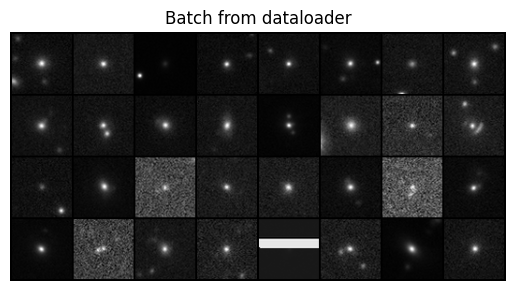

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


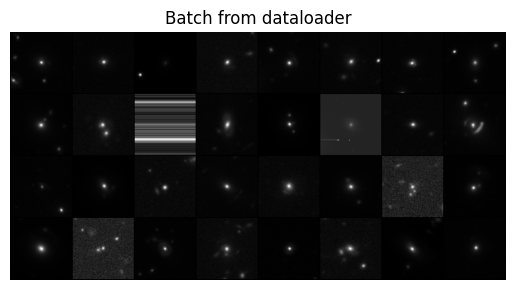

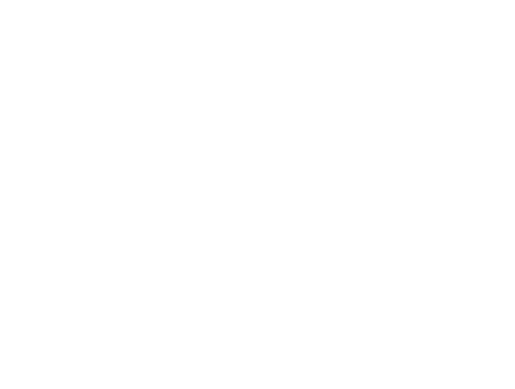

In [7]:
from torchvision import utils

def show_image_batch(sample_batched):
    """Show image for a batch of samples."""
    lr_batch, hr_batch = sample_batched['lr'], sample_batched['hr']
    batch_size = len(lr_batch)
    im_size = lr_batch.size(2)

    grid = utils.make_grid(lr_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

    grid = utils.make_grid(hr_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['lr'].size(), sample_batched['hr'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_image_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

RCAN Architecture 

In [8]:
class ChannelAttentionLayer(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ChannelAttentionLayer, self).__init__()
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channel, channel // reduction_ratio, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction_ratio, channel, kernel_size=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, features):
        attention = self.global_pooling(features)
        attention = self.channel_attention(attention)
        return features * attention

class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ResidualChannelAttentionBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            ChannelAttentionLayer(channel, reduction_ratio)
        )

    def forward(self, input_features):
        residual = self.conv_block(input_features)
        return input_features + residual


class ResidualGroup(nn.Module):
    def __init__(self, channel, num_blocks, reduction_ratio):
        super(ResidualGroup, self).__init__()
        blocks = [ResidualChannelAttentionBlock(channel, reduction_ratio) for _ in range(num_blocks)]
        blocks.append(nn.Conv2d(channel, channel, kernel_size=3, padding=1))
        self.group = nn.Sequential(*blocks)

    def forward(self, group_input):
        residual = self.group(group_input)
        return group_input + residual  # Use non-inplace addition

class ResidualChannelAttentionNetwork(nn.Module):
    def __init__(self, scale_factor=2, num_channels=1, feature_dim=64, num_residual_groups=2, num_rcab=4, reduction_ratio=16):
        super(ResidualChannelAttentionNetwork, self).__init__()
        self.initial_conv = nn.Conv2d(num_channels, feature_dim, kernel_size=3, padding=1)

        self.residual_groups = nn.Sequential(
            *[ResidualGroup(feature_dim, num_rcab, reduction_ratio) for _ in range(num_residual_groups)]
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )

        self.final_conv = nn.Conv2d(feature_dim, num_channels, kernel_size=3, padding=1)

    def forward(self, input_images):
        features = self.initial_conv(input_images)
        residual = self.residual_groups(features)
        features = features + residual  # Use non-inplace addition here as well
        upsampled = self.upsample(features)
        output = self.final_conv(upsampled)
        return output


In [9]:
state_dict = torch.load('RCAN.pth')
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

model = ResidualChannelAttentionNetwork()
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [10]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
# with scheduler 
def train(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=30):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        running_loss = 0.0
        total_batches = 0

        for data in train_loader:
            lr, hr = data['lr'].to(device), data['hr'].to(device)
            
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            total_batches += 1
        
        # Step the scheduler after each epoch
        scheduler.step()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / total_batches
        
        # Print loss after each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.8f}')

    print('Finished Training')


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
train(model, train_loader, criteria, optimizer, scheduler, device, num_epochs=30)

Epoch 1/30, Loss: 0.00448652
Epoch 2/30, Loss: 0.00214877
Epoch 3/30, Loss: 0.00157657
Epoch 4/30, Loss: 0.00136192
Epoch 5/30, Loss: 0.00132673
Epoch 6/30, Loss: 0.00126747
Epoch 7/30, Loss: 0.00124060
Epoch 8/30, Loss: 0.00123020
Epoch 9/30, Loss: 0.00120052
Epoch 10/30, Loss: 0.00118067
Epoch 11/30, Loss: 0.00114753
Epoch 12/30, Loss: 0.00114252
Epoch 13/30, Loss: 0.00113892
Epoch 14/30, Loss: 0.00113552
Epoch 15/30, Loss: 0.00113228
Epoch 16/30, Loss: 0.00112917
Epoch 17/30, Loss: 0.00112609
Epoch 18/30, Loss: 0.00112311
Epoch 19/30, Loss: 0.00112016
Epoch 20/30, Loss: 0.00111721
Epoch 21/30, Loss: 0.00111380
Epoch 22/30, Loss: 0.00111350
Epoch 23/30, Loss: 0.00111321
Epoch 24/30, Loss: 0.00111290
Epoch 25/30, Loss: 0.00111261
Epoch 26/30, Loss: 0.00111231
Epoch 27/30, Loss: 0.00111201
Epoch 28/30, Loss: 0.00111171
Epoch 29/30, Loss: 0.00111140
Epoch 30/30, Loss: 0.00111110
Finished Training


In [13]:
torch.save(model.state_dict(), 'RCAN_3B.pth')

In [14]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import mean_squared_error

def eval_model(model, test_loader, device):
    model.eval() 
    with torch.no_grad():  
        total_psnr = 0.0
        total_ssim = 0.0
        total_mse = 0.0
        total_images = 0
        
        for data in test_loader:
            lr, hr = data['lr'].to(device), data['hr'].to(device)
            sr = model(lr)
            
            sr_np = sr.cpu().numpy()
            hr_np = hr.cpu().numpy()
            
            batch_size = sr_np.shape[0]
            total_images += batch_size
            
            for i in range(batch_size):
                
                sr_img = sr_np[i].squeeze()  
                hr_img = hr_np[i].squeeze()
                
                psnr = compare_psnr(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                ssim = compare_ssim(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                mse = mean_squared_error(hr_img, sr_img)
                
                total_psnr += psnr
                total_ssim += ssim
                total_mse += mse
        
        # Calculate average PSNR, SSIM, and MSE
        avg_psnr = total_psnr / total_images
        avg_ssim = total_ssim / total_images
        avg_mse = total_mse / total_images
        
        print(f'Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}, Average MSE: {avg_mse:.4f}')

In [15]:
eval_model(model, test_loader, device)

Average PSNR: 34.1658, Average SSIM: 0.8036, Average MSE: 0.0012


In [16]:
# Function to visualize the images
def visualize_images(lr_image, sr_image, hr_image):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_image, cmap='gray')
    plt.title("Low-Resolution Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sr_image, cmap='gray')
    plt.title("Super-Resolution Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(hr_image, cmap='gray')
    plt.title("High-Resolution Target")
    plt.axis('off')

    plt.show()

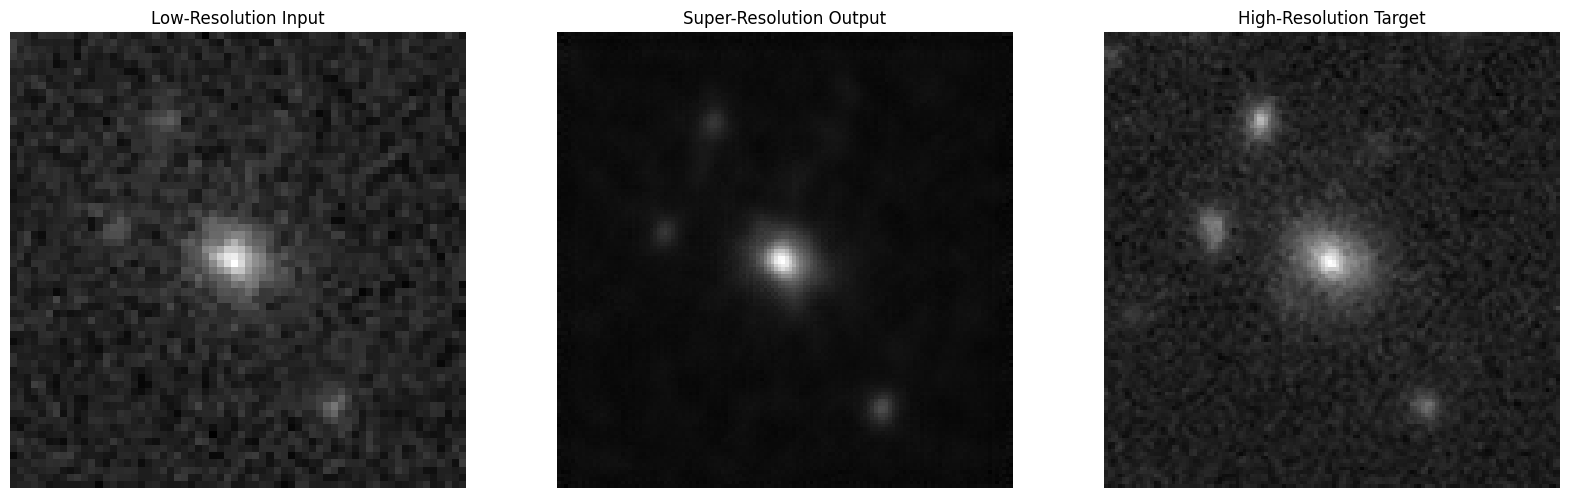

In [17]:
model.eval()  

data_iter = iter(test_loader)
data = next(data_iter)

lr, hr = data['lr'], data['hr']
lr, hr = lr.to(device), hr.to(device)

with torch.no_grad():
    sr = model(lr)  

lr_np = lr.cpu().squeeze().numpy()
hr_np = hr.cpu().squeeze().numpy()
sr_np = sr.cpu().squeeze().numpy()

visualize_images(lr_np[0], sr_np[0], hr_np[0])

The results show the Capability of RCAN to enhance the resolution of low-resolution images and generate high-resolution images with better quality.